In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date =(session.query(Measurement.date)
              .order_by(Measurement.date.desc()).first())

recent_date

('2017-08-23')

In [10]:
# Calculate the date one year from the last date in data set.
last_year_date=dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("Query Date:", last_year_date)

Query Date: 2016-08-22


In [11]:
# Perform a query to retrieve the data and precipitation scores
year_prcp =(session.query(Measurement.date,func.max(Measurement.prcp))
           .filter(func.strftime('%Y-%m-%d',Measurement.date) > last_year_date)
           .group_by(Measurement.date).all())
year_prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(year_prcp, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

prcp_df.head()

# Sort the dataframe by date
prcp_df.sort_values('date')

,precipitation
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


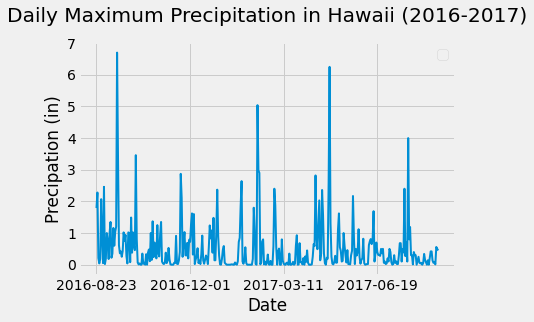

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(linewidth=2)
plt.title("Daily Maximum Precipitation in Hawaii (2016-2017)", pad=20)
plt.xlabel("Date")
plt.ylabel("Precipation (in)")
plt.legend('')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yearly_stats=(session.query(Measurement.date, Measurement.prcp)
             .filter(Measurement.date > last_year_date).all())

yearly_stats_df = pd.DataFrame(yearly_stats, columns=["date", "precipation"])
yearly_stats_df.dropna()

yearly_stats_df.describe()

,precipation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
print(f"There are {total_stations} total stations in Hawaii.")

There are 9 total stations in Hawaii.


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations=(session.query(Measurement.station,func.count(Measurement.station))
                .group_by(Measurement.station)
                .order_by(func.count(Measurement.station).desc()).all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs=[Measurement.station,
     func.min(Measurement.tobs),
     func.max(Measurement.tobs),
     func.avg(Measurement.tobs)]

most_active_st=(session.query(*tobs)
               .filter(Measurement.station=='USC00519281').all())
most_active_st_df=pd.DataFrame(most_active_st, columns=['station', 'min_temp', 
                                                       'max_temp', 'avg_temp'])
most_active_st_df.set_index('station', inplace=True)
most_active_st_df

,min_temp,max_temp,avg_temp
station,,,
USC00519281,54.0,85.0,71.663781


Text(0, 0.5, 'Frequency')

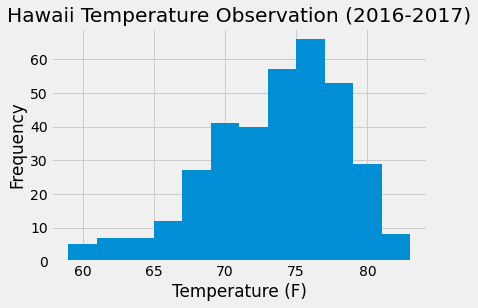

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
yearly_temp=(session.query(Measurement.date,(Measurement.tobs))
            .filter(func.strftime(Measurement.date) > last_year_date)
            .filter(Measurement.station=='USC00519281').all())

yearly_temp_df=pd.DataFrame(yearly_temp)
yearly_temp_df.set_index('date',inplace=True)

plt.hist(yearly_temp_df['tobs'], bins=12)
plt.title("Hawaii Temperature Observation (2016-2017)")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

# Close session

In [18]:
# Close Session
session.close()